### Final Project
<b>Tom Borgstadt</b></br>
<br>BUS 6316S Advanced Topics</br>
<br>Summer 2016</br>
<br>Portfolio Efficient Frontier<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cvxopt as opt
from cvxopt import blas, solvers, matrix
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

# from pandas_datareader import data, wb
import pandas_datareader.data as web

             Adj Close
Date                  
2015-06-30  201.481434
2015-07-31  206.032745
2015-08-31  193.475023
2015-09-30  188.538322
2015-10-30  204.575332
2015-11-30  205.323080
2015-12-31  201.774586
2016-01-29  191.728915
2016-02-29  191.570556
2016-03-31  204.456746
2016-04-29  205.262553
2016-05-31  208.754388
2016-06-30  209.479996
2016-07-29  209.919998
            Adj Close
Date                 
2015-06-30  42.680000
2015-07-31  41.639999
2015-08-31  44.099998
2015-09-30  45.020000
2015-10-30  41.400002
2015-11-30  41.180000
2015-12-31  41.740002
2016-01-29  43.799999
2016-02-29  43.700001
2016-03-31  40.820000
2016-04-29  40.619999
2016-05-31  39.860001
2016-06-30  39.660000
2016-07-29  39.570000
             Adj Close
Date                  
2015-06-30  269.483208
2015-07-31  269.769241
2015-08-31  254.489987
2015-09-30  246.351048
2015-10-30  260.030061
2015-11-30  263.504265
2015-12-31  252.444379
2016-01-29  238.462760
2016-02-29  241.414106
2016-03-31  261.894159
2016

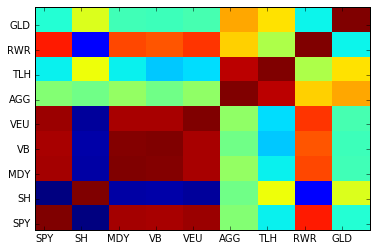

In [5]:
# Input is a simple csv of exchange traded funds of interest
df_etf = pd.read_csv('myetfs.csv')

# input return data and build a dataframe
startDate = '2015-06-30'
endDate   = '2016-07-01'

df_returns = pd.DataFrame()

for idx, row in df_etf.iterrows():
    df_sym = pd.DataFrame(web.get_data_yahoo(row['symbol'], start=startDate, end=endDate)['Adj Close'])
 
    # return the last value in the period
    period = 'BM'
    df_sym_tser = df_sym.resample(period).apply(lambda x: x[-1])

    print df_sym_tser
    # percent change from period to period
    df_sym_tser_chg = df_sym_tser.pct_change(periods=1)
    df_sym_tser_chg.columns=[row['symbol']]

    df_returns = df_returns.join(df_sym_tser_chg, how='outer')

df_returns.dropna(axis=0, inplace=True)
df_returns.to_csv('returns.csv')
print '\n', df_returns

etf_returns = np.asarray([df_returns[col].values for col in df_returns.columns])
print '\n', etf_returns

# Calculate correlation
df_corr = df_returns.corr()
print df_corr

# Print correlation visualization
plt.pcolor(df_corr)
plt.yticks(np.arange(0.25, len(df_corr.index), 1), df_corr.index)
plt.xticks(np.arange(0.25, len(df_corr.columns), 1), df_corr.columns)
plt.show()

In [160]:
# create n random values that sum to 1
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)


In [161]:
# Calculate the Expected Return and Risk for the passed returns
# If asset weights are not passed, use random weights
def portfolio_er(returns, weights):
    p = np.asmatrix(np.mean(returns, axis=1))
    
    if weights.any():
        w = np.asmatrix(weights)
    else:
        w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T                      # portfolio expected return (ER)
    sigma = np.sqrt(w * C * w.T)      # portfolio risk (SD)

    if debug == True:
        print 'stock returns (p):\n', p
        print 'stock weights (w):\n', w
        print 'covariance matrix (C):\n', C
        print 'portfolio expected return (mu):\n', mu
        print 'portfolio expected risk (sigma):\n', sigma

#    This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return portfolio_er(returns, weights)
    return mu, sigma

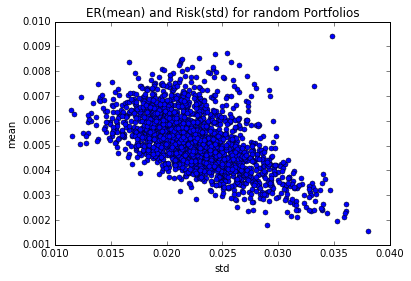

In [162]:
# Generate random portfolios
debug = 0
n_portfolios = 2000
means, stds = np.column_stack([
    portfolio_er(etf_returns, np.array([])) 
    for _ in xrange(n_portfolios)
])

# plot the random portfolios
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('ER(mean) and Risk(std) for random Portfolios')

In [163]:
def optimal_portfolio(returns, N=200):
    n = len(returns)
    
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
   
    P = opt.matrix(np.cov(returns))           # portfolio variance/covariance matrix
    q = opt.matrix(np.mean(returns, axis=1))  # portfolio assets expected returns
    
    # Create default constraint matrices
#     G = -opt.matrix(np.eye(n))   # default, negative n x n identity matrix
#     h = opt.matrix(0.0, (n ,1))  # default, no constraints

#     G = -opt.matrix(np.eye(n))   # default, negative n x n identity matrix
    G = -opt.matrix(0.0, (n,n))
    G[::n+1] = -1.0
    
    h = -opt.matrix(0.05, (n ,1))  # default, no constraints
    
    
# AH HA!  for 3 stock portfolio only
#     G = -opt.matrix([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
#     h = -opt.matrix([[0.05, 0.05, 0.05]])  # at least 5% in each stock
  
    # equality constraint Ax = b; captures the constraint sum(x) = 1
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    if debug == True:
        print 'P:\n', P
        print 'q:\n', q
        print 'G:\n', G
        print 'h:\n', h
        print 'A:\n', A
        print 'b:\n', b
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*P, -q, G, h, A, b)['x'] for mu in mus]
    
    # Calculate risks and returns for the frontier
    returns = [blas.dot(q, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, P*x)) for x in portfolios]
    
    # Calculate the 2nd degree (quadratic) polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    # Calculate the optimal portfolio
    wts = solvers.qp(opt.matrix(x1 * P), -q, G, h, A, b)['x']

    if debug == True:
        print 'm1: \n', m1
        print 'x1: \n', x1
    
    return np.asarray(wts), returns, risks

debug = 1
weights, returns, risks = optimal_portfolio(etf_returns,N=200)
print 'weights:\n', weights
# print '\nreturns:\n', returns
# print '\nrisks:\n', risks


P:
[ 3.25e-03 -4.98e-04 -3.32e-04 -3.82e-04  3.28e-04  1.81e-04]
[-4.98e-04  1.63e-03  1.55e-03  1.68e-03 -1.89e-04  6.11e-06]
[-3.32e-04  1.55e-03  1.69e-03  1.84e-03 -1.91e-04  1.60e-05]
[-3.82e-04  1.68e-03  1.84e-03  2.03e-03 -2.67e-04 -7.50e-06]
[ 3.28e-04 -1.89e-04 -1.91e-04 -2.67e-04  2.81e-04  1.03e-04]
[ 1.81e-04  6.11e-06  1.60e-05 -7.50e-06  1.03e-04  4.71e-05]

q:
[ 1.18e-02]
[ 3.90e-03]
[ 1.71e-03]
[-1.07e-03]
[ 9.81e-03]
[ 4.81e-03]

G:
[-1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00]

h:
[-5.00e-02]
[-5.00e-02]
[-5.00e-02]
[-5.00e-02]
[-5.00e-02]
[-5.00e-02]

A:
[ 1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00]

b:
[ 1.00e+00]

m1: 
[  3.4456

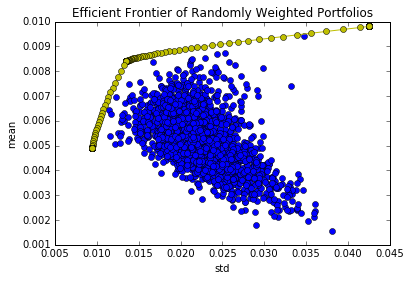

In [164]:
# plot
plt.plot(stds, means, 'o')
plt.xlabel('std')
plt.ylabel('mean')
plt.plot(risks, returns, 'y-o')
plt.title('Efficient Frontier of Randomly Weighted Portfolios')

In [165]:
print weights.T

portfolio_er(etf_returns, weights.T)

[[ 0.7499999   0.05000002  0.05000002  0.05000001  0.05000002  0.05000003]]
stock returns (p):
[[ 0.01179808  0.00390293  0.00171069 -0.0010672   0.00981007  0.00480531]]
stock weights (w):
[[ 0.7499999   0.05000002  0.05000002  0.05000001  0.05000002  0.05000003]]
covariance matrix (C):
[[  3.24819170e-03  -4.97573987e-04  -3.31709627e-04  -3.81543950e-04
    3.27743119e-04   1.80533197e-04]
 [ -4.97573987e-04   1.62924575e-03   1.55047318e-03   1.68095625e-03
   -1.88686339e-04   6.11124120e-06]
 [ -3.31709627e-04   1.55047318e-03   1.69222252e-03   1.83624008e-03
   -1.90688242e-04   1.60257064e-05]
 [ -3.81543950e-04   1.68095625e-03   1.83624008e-03   2.02976007e-03
   -2.67358143e-04  -7.49794400e-06]
 [  3.27743119e-04  -1.88686339e-04  -1.90688242e-04  -2.67358143e-04
    2.80591107e-04   1.03113045e-04]
 [  1.80533197e-04   6.11124120e-06   1.60257064e-05  -7.49794400e-06
    1.03113045e-04   4.71086206e-05]]
portfolio expected return (mu):
[[ 0.00980665]]
portfolio expected r

(matrix([[ 0.00980665]]), matrix([[ 0.04255945]]))

## References

https://web.archive.org/web/20150404034126/http://stanford.edu/~mwaskom/software/seaborn/tutorial/dataset_exploration.html


http://stanford.edu/~mwaskom/software/seaborn-dev/generated/seaborn.heatmap.html


## Troubleshooting

There are a couple of things that you can try:

1) Check how your constraints are scaled and rescale if necessary (see e.g. https://groups.google.com/forum/#!topic/cvxopt/IstFuvQqXtM or https://groups.google.com/forum/#!topic/cvxopt/MeEq5Q1Har0).

2) Change the default tolerances in the options dictionary (see http://cvxopt.org/userguide/coneprog.html#algorithm-parameters).

If these suggestions do not help, I'd be happy to help if you can send me a problem instance.